In [2]:
!pip install torch torchvision matplotlib scikit-learn

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder('fruits-360/Training', transform=transform)
test_data = datasets.ImageFolder('fruits-360/Test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)
print(f"Кількість класів: {num_classes}")


Кількість класів: 64


In [25]:
class FruitCNN(nn.Module):
    def __init__(self, num_classes):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 25 * 25, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)  # ← виправлено тут
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [26]:
def train_model(model, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [27]:
def evaluate(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.show()


In [29]:
model = FruitCNN(num_classes)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

train_model(model, optimizer, criterion, epochs=10)


Epoch 1/10, Loss: 0.7280
Epoch 2/10, Loss: 0.0780
Epoch 3/10, Loss: 0.0495
Epoch 4/10, Loss: 0.0369
Epoch 5/10, Loss: 0.0434
Epoch 6/10, Loss: 0.0362
Epoch 7/10, Loss: 0.0223
Epoch 8/10, Loss: 0.0252
Epoch 9/10, Loss: 0.0316
Epoch 10/10, Loss: 0.0235


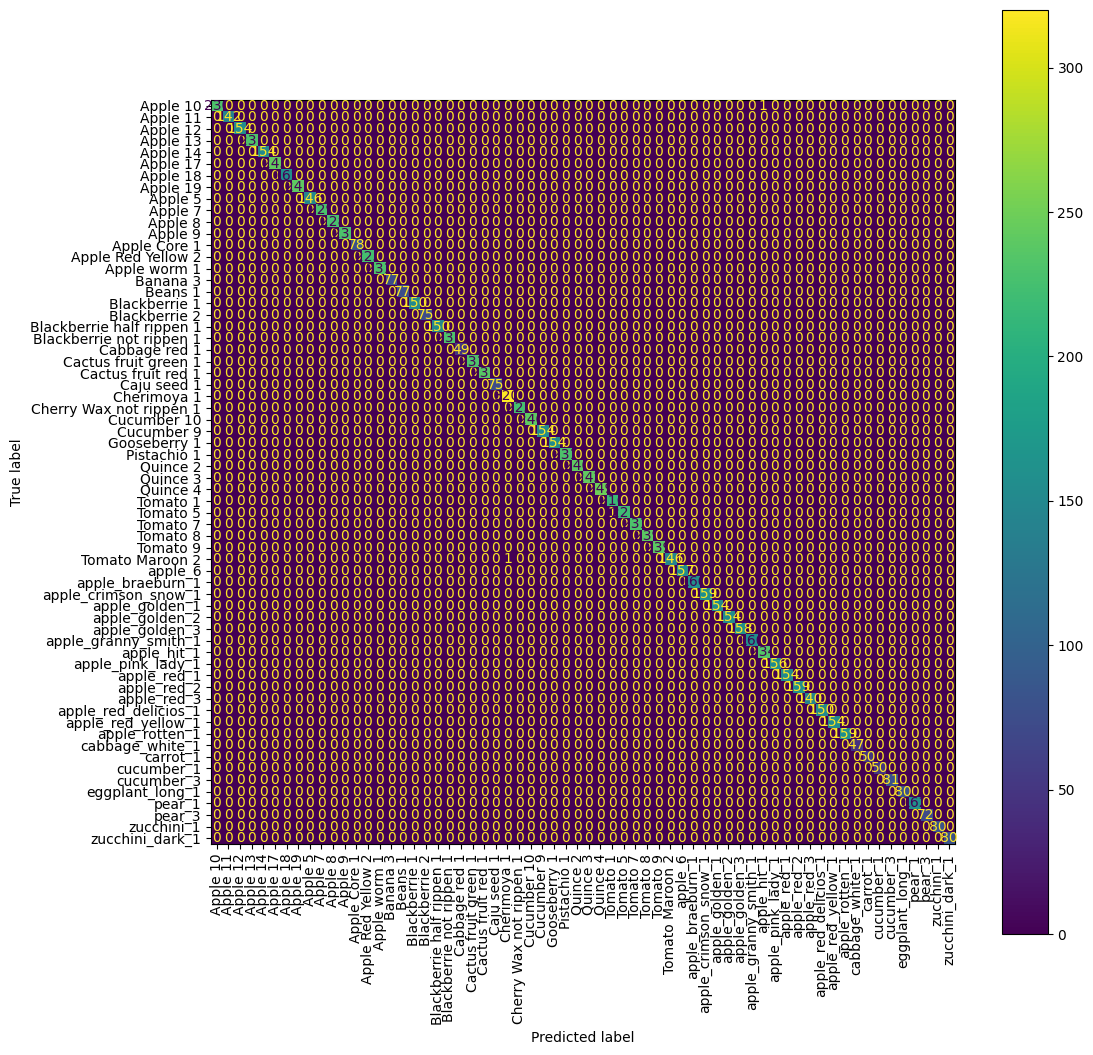

In [30]:
evaluate(model)


In [31]:
predict_image("r0_4.jpg", model)


Передбачено: Apple 7
